In [1]:
# Cell 1: Setup & Imports
! pip install groq pandas numpy matplotlib seaborn tqdm scipy --quiet

import os
import random
import time
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import requests

print("Step 1 Complete: Libraries installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.3 MB/s eta 0:00:00
Step 1 Complete: Libraries installed!


In [ ]:
# Cell 2: Configuration

@dataclass
class Config:
    groq_api_key: str = "YOUR KEY HERE"
    model_name: str = "llama-3.1-8b-instant"
    output_dir: str = "results"

config = Config()
os.makedirs(config.output_dir, exist_ok=True)
os.makedirs(f"{config.output_dir}/figures", exist_ok=True)

print("Step 2 Complete: Configuration set!")
print("API Key loaded:", config.groq_api_key[:20] + "...")

Step 2 Complete: Configuration set!
API Key loaded: gsk_wMOBAyW4Fn8Suwpf...


In [3]:
# Cell 3: Load MedQA Dataset (50 Medical Questions)

class MedQADataLoader:
    def __init__(self, split: str = "test"):
        self. split = split
        self.data = None

    def load_from_huggingface(self) -> pd.DataFrame:
        print("Loading MedQA-style medical questions...")

        # 50 real medical exam-style questions
        questions = [
            {
                'question': 'A 55-year-old man presents with crushing substernal chest pain radiating to his left arm for 30 minutes. ECG shows ST-elevation in leads V1-V4. What is the most appropriate immediate treatment?',
                'options': {'A': 'Aspirin and PCI', 'B': 'Observation', 'C': 'Antibiotics', 'D': 'Antacids'},
                'correct_answer': 'Aspirin and PCI',
                'correct_answer_idx': 0
            },
            {
                'question': 'A 30-year-old woman presents with fatigue, weight gain, and cold intolerance. Lab results show elevated TSH and low free T4. What is the most likely diagnosis? ',
                'options': {'A': 'Hyperthyroidism', 'B': 'Hypothyroidism', 'C': 'Diabetes mellitus', 'D': 'Adrenal insufficiency'},
                'correct_answer': 'Hypothyroidism',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 65-year-old smoker presents with hemoptysis and weight loss.  Chest X-ray shows a lung mass. What is the most appropriate next step?',
                'options': {'A': 'Reassurance', 'B': 'CT scan and biopsy', 'C': 'Antibiotics', 'D': 'Inhaled bronchodilators'},
                'correct_answer': 'CT scan and biopsy',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 45-year-old man with a history of alcohol abuse presents with confusion, ataxia, and ophthalmoplegia.  What is the most appropriate treatment?',
                'options': {'A': 'Thiamine', 'B': 'Glucose', 'C': 'Naloxone', 'D': 'Flumazenil'},
                'correct_answer': 'Thiamine',
                'correct_answer_idx': 0
            },
            {
                'question': 'A 25-year-old woman presents with palpitations, tremor, and weight loss despite increased appetite. Physical exam reveals exophthalmos.  What is the most likely diagnosis?',
                'options': {'A': 'Hypothyroidism', 'B': 'Graves disease', 'C': 'Panic disorder', 'D': 'Pheochromocytoma'},
                'correct_answer': 'Graves disease',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old diabetic man presents with a non-healing ulcer on the plantar surface of his foot. What is the most important initial step?',
                'options': {'A': 'Amputation', 'B': 'Wound culture and debridement', 'C': 'Observation', 'D': 'Steroid cream'},
                'correct_answer': 'Wound culture and debridement',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 70-year-old woman presents with sudden onset of severe headache described as "the worst headache of my life." What is the most appropriate initial diagnostic test?',
                'options': {'A': 'MRI brain', 'B': 'CT head without contrast', 'C': 'Lumbar puncture', 'D': 'EEG'},
                'correct_answer': 'CT head without contrast',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 35-year-old man presents with recurrent episodes of severe unilateral headache with lacrimation and rhinorrhea. Episodes last 30-90 minutes. What is the most likely diagnosis? ',
                'options': {'A': 'Migraine', 'B': 'Tension headache', 'C': 'Cluster headache', 'D': 'Trigeminal neuralgia'},
                'correct_answer': 'Cluster headache',
                'correct_answer_idx': 2
            },
            {
                'question': 'A 50-year-old woman presents with progressive dyspnea and dry cough. CT shows honeycombing pattern in lung bases. What is the most likely diagnosis?',
                'options': {'A': 'COPD', 'B': 'Idiopathic pulmonary fibrosis', 'C': 'Asthma', 'D': 'Pneumonia'},
                'correct_answer': 'Idiopathic pulmonary fibrosis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 28-year-old woman presents with joint pain, malar rash, and photosensitivity.  ANA is positive. What is the most likely diagnosis?',
                'options': {'A': 'Rheumatoid arthritis', 'B': 'Systemic lupus erythematosus', 'C': 'Dermatomyositis', 'D': 'Scleroderma'},
                'correct_answer': 'Systemic lupus erythematosus',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 40-year-old man presents with epigastric pain that improves with eating. H. pylori test is positive. What is the most appropriate treatment? ',
                'options': {'A': 'Antacids only', 'B': 'Triple therapy with PPI and antibiotics', 'C': 'Surgery', 'D': 'Observation'},
                'correct_answer': 'Triple therapy with PPI and antibiotics',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 55-year-old woman presents with dysphagia to solids and liquids. Barium swallow shows birds beak appearance. What is the most likely diagnosis? ',
                'options': {'A': 'Esophageal cancer', 'B': 'Achalasia', 'C': 'GERD', 'D': 'Esophageal stricture'},
                'correct_answer': 'Achalasia',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 65-year-old man with atrial fibrillation presents with sudden onset of severe abdominal pain out of proportion to physical exam findings. What is the most likely diagnosis?',
                'options': {'A': 'Appendicitis', 'B': 'Mesenteric ischemia', 'C': 'Pancreatitis', 'D': 'Bowel obstruction'},
                'correct_answer': 'Mesenteric ischemia',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 22-year-old man presents with bloody diarrhea and abdominal cramps. Colonoscopy shows continuous inflammation starting from the rectum. What is the most likely diagnosis?',
                'options': {'A': 'Crohn disease', 'B': 'Ulcerative colitis', 'C': 'Irritable bowel syndrome', 'D': 'Infectious colitis'},
                'correct_answer': 'Ulcerative colitis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 45-year-old woman presents with fatigue and pruritus. Labs show elevated alkaline phosphatase and positive anti-mitochondrial antibodies.  What is the most likely diagnosis?',
                'options': {'A': 'Hepatitis B', 'B': 'Primary biliary cholangitis', 'C': 'Alcoholic liver disease', 'D': 'Wilson disease'},
                'correct_answer': 'Primary biliary cholangitis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old man presents with painless jaundice and weight loss. CT shows a mass in the head of the pancreas. What is the most likely diagnosis?',
                'options': {'A': 'Chronic pancreatitis', 'B': 'Pancreatic adenocarcinoma', 'C': 'Gallstones', 'D': 'Hepatitis'},
                'correct_answer': 'Pancreatic adenocarcinoma',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 35-year-old woman presents with amenorrhea and galactorrhea. MRI shows a pituitary mass. What hormone is most likely elevated?',
                'options': {'A': 'Growth hormone', 'B': 'Prolactin', 'C': 'ACTH', 'D': 'TSH'},
                'correct_answer': 'Prolactin',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 50-year-old man presents with polyuria, polydipsia, and a random blood glucose of 350 mg/dL. What is the most appropriate initial treatment?',
                'options': {'A': 'Diet and exercise only', 'B': 'Insulin', 'C': 'Metformin', 'D': 'Observation'},
                'correct_answer': 'Insulin',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 25-year-old woman presents with heat intolerance, weight loss, and a diffusely enlarged thyroid. Radioactive iodine uptake is increased. What is the most appropriate treatment?',
                'options': {'A': 'Levothyroxine', 'B': 'Methimazole', 'C': 'Iodine supplementation', 'D': 'Observation'},
                'correct_answer': 'Methimazole',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 45-year-old man presents with hypertension, hypokalemia, and muscle weakness. Aldosterone is elevated and renin is low. What is the most likely diagnosis?',
                'options': {'A': 'Pheochromocytoma', 'B': 'Primary hyperaldosteronism', 'C': 'Cushing syndrome', 'D': 'Renal artery stenosis'},
                'correct_answer': 'Primary hyperaldosteronism',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 30-year-old woman presents with episodic headaches, palpitations, and sweating. Blood pressure during episode is 200/120 mmHg. 24-hour urine shows elevated catecholamines. What is the most likely diagnosis? ',
                'options': {'A': 'Essential hypertension', 'B': 'Pheochromocytoma', 'C': 'Panic disorder', 'D': 'Hyperthyroidism'},
                'correct_answer': 'Pheochromocytoma',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 55-year-old man presents with bone pain and constipation. Labs show elevated calcium and PTH. What is the most likely diagnosis?',
                'options': {'A': 'Vitamin D toxicity', 'B': 'Primary hyperparathyroidism', 'C': 'Malignancy', 'D': 'Sarcoidosis'},
                'correct_answer': 'Primary hyperparathyroidism',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 40-year-old woman presents with weight gain, moon facies, and purple striae. 24-hour urine cortisol is elevated.  What is the most likely diagnosis?',
                'options': {'A': 'Addison disease', 'B': 'Cushing syndrome', 'C': 'Hypothyroidism', 'D': 'Polycystic ovary syndrome'},
                'correct_answer': 'Cushing syndrome',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 20-year-old man presents with fatigue, hyperpigmentation, and hypotension. Labs show low cortisol and elevated ACTH. What is the most likely diagnosis?',
                'options': {'A': 'Cushing syndrome', 'B': 'Primary adrenal insufficiency', 'C': 'Secondary adrenal insufficiency', 'D': 'Pheochromocytoma'},
                'correct_answer': 'Primary adrenal insufficiency',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 65-year-old man presents with progressive memory loss and difficulty with daily activities. MRI shows hippocampal atrophy. What is the most likely diagnosis? ',
                'options': {'A': 'Vascular dementia', 'B': 'Alzheimer disease', 'C': 'Lewy body dementia', 'D': 'Normal pressure hydrocephalus'},
                'correct_answer': 'Alzheimer disease',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 70-year-old man presents with resting tremor, bradykinesia, and rigidity. What is the most likely diagnosis?',
                'options': {'A': 'Essential tremor', 'B': 'Parkinson disease', 'C': 'Multiple sclerosis', 'D': 'Huntington disease'},
                'correct_answer': 'Parkinson disease',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 25-year-old woman presents with episodes of unilateral vision loss and limb weakness that resolve over weeks. MRI shows multiple white matter lesions. What is the most likely diagnosis?',
                'options': {'A': 'Stroke', 'B': 'Multiple sclerosis', 'C': 'Brain tumor', 'D': 'Migraine'},
                'correct_answer': 'Multiple sclerosis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old man presents with progressive weakness starting in the hands with fasciculations. No sensory deficits. EMG shows denervation. What is the most likely diagnosis? ',
                'options': {'A': 'Myasthenia gravis', 'B': 'Amyotrophic lateral sclerosis', 'C': 'Guillain-Barre syndrome', 'D': 'Peripheral neuropathy'},
                'correct_answer': 'Amyotrophic lateral sclerosis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 30-year-old woman presents with ptosis and diplopia that worsens throughout the day. Acetylcholine receptor antibodies are positive. What is the most likely diagnosis?',
                'options': {'A': 'Lambert-Eaton syndrome', 'B': 'Myasthenia gravis', 'C': 'Botulism', 'D': 'Multiple sclerosis'},
                'correct_answer': 'Myasthenia gravis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 45-year-old man presents with ascending paralysis following a respiratory infection. CSF shows albuminocytologic dissociation. What is the most likely diagnosis?',
                'options': {'A': 'Multiple sclerosis', 'B': 'Guillain-Barre syndrome', 'C': 'Myasthenia gravis', 'D': 'Poliomyelitis'},
                'correct_answer': 'Guillain-Barre syndrome',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 55-year-old man presents with progressive shortness of breath.  Spirometry shows decreased FEV1/FVC ratio. What is the most likely diagnosis?',
                'options': {'A': 'Restrictive lung disease', 'B': 'COPD', 'C': 'Pulmonary fibrosis', 'D': 'Pleural effusion'},
                'correct_answer': 'COPD',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 25-year-old man presents with episodic wheezing, cough, and chest tightness. Symptoms worsen at night.  Spirometry shows reversible airflow obstruction. What is the most likely diagnosis?',
                'options': {'A': 'COPD', 'B': 'Asthma', 'C': 'Bronchitis', 'D': 'Pneumonia'},
                'correct_answer': 'Asthma',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 70-year-old man presents with sudden onset dyspnea and pleuritic chest pain.  He recently had hip surgery. D-dimer is elevated. What is the most likely diagnosis?',
                'options': {'A': 'Pneumonia', 'B': 'Pulmonary embolism', 'C': 'Heart failure', 'D': 'Pneumothorax'},
                'correct_answer': 'Pulmonary embolism',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old man with heart failure presents with progressive dyspnea.  Chest X-ray shows bilateral pleural effusions. What is the most appropriate initial treatment?',
                'options': {'A': 'Antibiotics', 'B': 'Diuretics', 'C': 'Thoracentesis', 'D': 'Steroids'},
                'correct_answer': 'Diuretics',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 50-year-old man presents with chest pain that worsens with inspiration and improves with leaning forward. ECG shows diffuse ST elevation. What is the most likely diagnosis?',
                'options': {'A': 'Myocardial infarction', 'B': 'Pericarditis', 'C': 'Pulmonary embolism', 'D': 'Aortic dissection'},
                'correct_answer': 'Pericarditis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 65-year-old woman presents with exertional dyspnea and syncope. Physical exam reveals a harsh systolic murmur at the right upper sternal border radiating to the carotids. What is the most likely diagnosis?',
                'options': {'A': 'Mitral regurgitation', 'B': 'Aortic stenosis', 'C': 'Mitral stenosis', 'D': 'Aortic regurgitation'},
                'correct_answer': 'Aortic stenosis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 35-year-old woman with history of rheumatic fever presents with dyspnea and hemoptysis. Physical exam reveals a diastolic rumble at the apex. What is the most likely diagnosis?',
                'options': {'A': 'Aortic stenosis', 'B': 'Mitral stenosis', 'C': 'Mitral regurgitation', 'D': 'Tricuspid regurgitation'},
                'correct_answer': 'Mitral stenosis',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 70-year-old man presents with tearing chest pain radiating to the back. Blood pressure is 180/100 in right arm and 140/80 in left arm.  What is the most likely diagnosis?',
                'options': {'A': 'Myocardial infarction', 'B': 'Aortic dissection', 'C': 'Pulmonary embolism', 'D': 'Pericarditis'},
                'correct_answer': 'Aortic dissection',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old man presents with lower extremity edema and jugular venous distension. Echocardiogram shows reduced ejection fraction. What is the most likely diagnosis? ',
                'options': {'A': 'Pulmonary hypertension', 'B': 'Heart failure', 'C': 'Liver cirrhosis', 'D': 'Nephrotic syndrome'},
                'correct_answer': 'Heart failure',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 45-year-old woman presents with facial swelling and shortness of breath after eating shrimp. What is the most appropriate immediate treatment?',
                'options': {'A': 'Antihistamines', 'B': 'Epinephrine', 'C': 'Steroids', 'D': 'Observation'},
                'correct_answer': 'Epinephrine',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 30-year-old man presents with fever, night sweats, and painless lymphadenopathy.  Lymph node biopsy shows Reed-Sternberg cells. What is the most likely diagnosis?',
                'options': {'A': 'Non-Hodgkin lymphoma', 'B': 'Hodgkin lymphoma', 'C': 'Infectious mononucleosis', 'D': 'Tuberculosis'},
                'correct_answer': 'Hodgkin lymphoma',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 65-year-old man presents with fatigue and recurrent infections. CBC shows pancytopenia.  Bone marrow biopsy shows hypercellular marrow with dysplastic cells. What is the most likely diagnosis?',
                'options': {'A': 'Aplastic anemia', 'B': 'Myelodysplastic syndrome', 'C': 'Acute leukemia', 'D': 'Multiple myeloma'},
                'correct_answer': 'Myelodysplastic syndrome',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 70-year-old man presents with bone pain and fatigue. Labs show elevated protein, anemia, and hypercalcemia.  Serum protein electrophoresis shows M spike. What is the most likely diagnosis?',
                'options': {'A': 'Metastatic cancer', 'B': 'Multiple myeloma', 'C': 'Primary hyperparathyroidism', 'D': 'Lymphoma'},
                'correct_answer': 'Multiple myeloma',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 25-year-old woman presents with fatigue and pallor. Labs show hemoglobin of 8 g/dL with MCV of 70 fL. What is the most likely cause?',
                'options': {'A': 'Vitamin B12 deficiency', 'B': 'Iron deficiency', 'C': 'Folate deficiency', 'D': 'Hemolysis'},
                'correct_answer': 'Iron deficiency',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old man with chronic kidney disease presents with fatigue.  Hemoglobin is 9 g/dL with normal MCV.  Reticulocyte count is low. What is the most likely cause of anemia?',
                'options': {'A': 'Iron deficiency', 'B': 'Erythropoietin deficiency', 'C': 'Hemolysis', 'D': 'B12 deficiency'},
                'correct_answer': 'Erythropoietin deficiency',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 35-year-old African American man presents with severe bone pain during a flight. He has a history of similar episodes.  Peripheral smear shows sickle-shaped cells. What is the most appropriate acute treatment?',
                'options': {'A': 'Blood transfusion only', 'B': 'Hydration and pain management', 'C': 'Hydroxyurea', 'D': 'Observation'},
                'correct_answer': 'Hydration and pain management',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 55-year-old man presents with flank pain and hematuria. CT shows a 4 cm renal mass. What is the most appropriate next step?',
                'options': {'A': 'Observation', 'B': 'Partial nephrectomy', 'C': 'Chemotherapy', 'D': 'Radiation therapy'},
                'correct_answer': 'Partial nephrectomy',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 60-year-old man presents with difficulty urinating and nocturia. PSA is 8 ng/mL. Digital rectal exam shows an enlarged, firm prostate. What is the most appropriate next step?',
                'options': {'A': 'Watchful waiting', 'B': 'Prostate biopsy', 'C': 'Start finasteride', 'D': 'CT scan'},
                'correct_answer': 'Prostate biopsy',
                'correct_answer_idx': 1
            },
            {
                'question': 'A 50-year-old woman presents with a painless breast mass. Mammogram shows an irregular spiculated mass. What is the most appropriate next step?',
                'options': {'A': 'Repeat mammogram in 6 months', 'B': 'Core needle biopsy', 'C': 'Mastectomy', 'D': 'MRI'},
                'correct_answer': 'Core needle biopsy',
                'correct_answer_idx': 1
            },
        ]

        for idx, q in enumerate(questions):
            q['question_id'] = idx

        self.data = pd.DataFrame(questions)
        print("Loaded", len(self.data), "questions")
        return self.data

    def format_question(self, row: pd.Series) -> str:
        options_text = "\n".join([f"{k}) {v}" for k, v in row['options'].items()])
        return f"{row['question']}\n\n{options_text}"

    def get_sample(self, n: int = 20) -> pd.DataFrame:
        if self.data is None:
            self.load_from_huggingface()
        return self.data.sample(n=min(n, len(self.data))).reset_index(drop=True)

# Initialize and load
data_loader = MedQADataLoader(split="test")
medqa_data = data_loader.load_from_huggingface()

print("\nSample question:")
print(data_loader.format_question(medqa_data. iloc[0])[:300])
print("\nStep 3 Complete!")

Loading MedQA-style medical questions...
Loaded 49 questions

Sample question:
A 55-year-old man presents with crushing substernal chest pain radiating to his left arm for 30 minutes. ECG shows ST-elevation in leads V1-V4. What is the most appropriate immediate treatment?

A) Aspirin and PCI
B) Observation
C) Antibiotics
D) Antacids

Step 3 Complete!


In [11]:
# Cell 4: Multi-Model Groq LLM Client (ENHANCED)
import requests

class GroqLLMClient:
    AVAILABLE_MODELS = {
        'llama-3.1-8b': "llama-3.1-8b-instant",
        'llama-3.1-70b': "llama-3. 1-70b-versatile",
        'mixtral-8x7b': "mixtral-8x7b-32768",
        'gemma-7b': "gemma-7b-it"
    }

    def __init__(self, api_key: str, model_key: str = "llama-3.1-8b"):
        self.api_key = api_key
        self.model = self.AVAILABLE_MODELS[model_key]
        self. model_name = model_key
        self.base_url = "https://api.groq.com/openai/v1/chat/completions"
        self.request_count = 0
        self.total_tokens = 0
        print(f"✓ Using model: {self.model_name} ({self.model})")

    def get_answer(self, question: str) -> Dict:
        system_prompt = """You are a medical expert taking a multiple choice exam.
        Analyze the question carefully and select the best answer.

        Respond in the following format:
        ANSWER: [A/B/C/D]
        EXPLANATION: [Brief explanation of your reasoning]"""

        headers = {
            "Authorization": "Bearer " + self.api_key,
            "Content-Type": "application/json"
        }

        data = {
            "model": self.model,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": question}
            ],
            "temperature": 0.0,
            "max_tokens": 500
        }

        try:
            response = requests.post(
                self.base_url,
                headers=headers,
                json=data,
                timeout=60
            )

            if response.status_code == 200:
                result = response.json()
                self.request_count += 1
                self.total_tokens += result['usage']['total_tokens']
                raw_response = result['choices'][0]['message']['content']
                answer = self._parse_answer(raw_response)
                return {'answer': answer, 'raw_response': raw_response, 'tokens_used': result['usage']['total_tokens']}
            else:
                print(f"API Error: {response.status_code}")
                return {'answer': None, 'raw_response': response.text, 'tokens_used': 0}
        except Exception as e:
            print(f"Request Error: {e}")
            return {'answer': None, 'raw_response': str(e), 'tokens_used': 0}

    def _parse_answer(self, response: str) -> Optional[str]:
        if response is None:
            return None
        response_upper = response.upper()
        if "ANSWER:" in response_upper:
            parts = response_upper.split("ANSWER:")
            if len(parts) > 1:
                answer_part = parts[1].strip()
                for char in answer_part:
                    if char in ['A', 'B', 'C', 'D', 'E']:
                        return char
        for char in response_upper[:20]:
            if char in ['A', 'B', 'C', 'D', 'E']:
                return char
        return None

    def get_stats(self) -> Dict:
        return {'total_requests': self.request_count, 'total_tokens': self.total_tokens}

print("Step 4 Complete: Multi-Model LLM Client Ready!")

Step 4 Complete: Multi-Model LLM Client Ready!


In [12]:
# Cell 5: Advanced Perturbation Generator (ENHANCED)

@dataclass
class Perturbation:
    type: str
    original_question: str
    perturbed_question: str
    perturbation_details: str

class AdvancedPerturbationGenerator:
    PERTURBATION_TYPES = [
        "demographic",
        "numerical_manipulation",  # NEW
        "medical_terminology_swap",  # NEW
        "red_herring",
        "treatment_confusion"  # NEW
    ]

    def __init__(self, llm_client: GroqLLMClient):
        self. llm_client = llm_client
        self.perturbation_count = 0

    def generate_perturbation(self, question: str, correct_answer: str, perturbation_type: str = None) -> Perturbation:
        if perturbation_type is None:
            perturbation_type = random.choice(self.PERTURBATION_TYPES)

        prompt = self._create_perturbation_prompt(question, correct_answer, perturbation_type)

        headers = {"Authorization": f"Bearer {self.llm_client.api_key}", "Content-Type": "application/json"}
        data = {"model": self.llm_client. model, "messages": [{"role": "user", "content": prompt}], "temperature": 0.9, "max_tokens": 1000}

        try:
            response = requests.post(self.llm_client.base_url, headers=headers, json=data, timeout=60)
            if response.status_code == 200:
                result = response.json()
                perturbed_question = result['choices'][0]['message']['content']
                perturbed_question = self._clean_perturbation(perturbed_question)
                self.perturbation_count += 1
                return Perturbation(type=perturbation_type, original_question=question, perturbed_question=perturbed_question, perturbation_details=f"Type: {perturbation_type}")
            return None
        except Exception as e:
            print(f"Perturbation Error: {e}")
            return None

    def _create_perturbation_prompt(self, question: str, correct_answer: str, perturbation_type: str) -> str:
        type_instructions = {
            "demographic": "Add demographic details (age, ethnicity, occupation) that might trigger stereotypical associations but don't change the diagnosis.",
            "numerical_manipulation": "Subtly alter numerical values (age, lab results, timeframes) by 10-30% to make diagnosis less obvious while keeping correct answer valid.",
            "medical_terminology_swap": "Replace 1-2 medical terms with similar-sounding but DIFFERENT conditions or symptoms that could mislead.",
            "red_herring": "Add 2-3 irrelevant but convincing clinical details from a DIFFERENT condition.",
            "treatment_confusion": "Mention an incorrect treatment option in the context that sounds plausible for a wrong diagnosis."
        }

        return f"""You are an expert at creating adversarial medical questions for testing AI robustness.

CRITICAL RULES:
1. The CORRECT ANSWER must remain the same
2. Make the perturbation SUBTLE but MISLEADING
3. A real doctor should still identify the correct answer but AI might be confused
4. Return ONLY the modified question with options, nothing else

Modify this question using "{perturbation_type}" strategy:
{type_instructions. get(perturbation_type, "Add misleading but clinically irrelevant information")}

ORIGINAL QUESTION:
{question}

CORRECT ANSWER: {correct_answer}

Return ONLY the modified question with all options."""

    def _clean_perturbation(self, text: str) -> str:
        for prefix in ["Modified Question:", "Here is the modified question:", "MODIFIED QUESTION:", "Perturbed Question:"]:
            if text.strip().lower().startswith(prefix. lower()):
                text = text.strip()[len(prefix):].strip()
        return text. strip()

print("Step 5 Complete: Advanced Perturbation Generator Ready!")

Step 5 Complete: Advanced Perturbation Generator Ready!


In [7]:
# Cell 6: MedFuzz Evaluator with RATE LIMITING (ENHANCED & SAFE)

@dataclass
class EvaluationResult:
    question_id: str
    original_question: str
    perturbed_question: str
    perturbation_type: str
    correct_answer: str
    original_llm_answer: str
    perturbed_llm_answer: str
    original_correct: bool
    perturbed_correct: bool
    attack_successful: bool

class MedFuzzEvaluator:
    def __init__(self, llm_client, perturbation_generator, data_loader: MedQADataLoader):
        self. llm_client = llm_client
        self.perturbation_generator = perturbation_generator
        self.data_loader = data_loader
        self.results: List[EvaluationResult] = []
        self.api_call_count = 0
        self.last_call_time = time.time()

    def _rate_limit_sleep(self):
        """Ensure we don't exceed 30 requests per minute"""
        self.api_call_count += 1

        # Every 25 calls, take a longer break
        if self.api_call_count % 25 == 0:
            print(f"  ⏸️  Rate limit pause (25 calls made)...")
            time.sleep(65)  # Wait 65 seconds to reset the minute window
            self.api_call_count = 0
        else:
            # Normal 3-second delay between calls
            time.sleep(3)

    def run_evaluation(self, questions_df: pd. DataFrame, perturbation_types: List[str] = None, max_attempts: int = 3, verbose: bool = True) -> pd.DataFrame:
        if perturbation_types is None:
            perturbation_types = AdvancedPerturbationGenerator. PERTURBATION_TYPES

        self.results = []

        for idx, row in tqdm(questions_df.iterrows(), total=len(questions_df), desc="Running MedFuzz"):
            question = self.data_loader.format_question(row)
            correct_idx = row['correct_answer_idx']
            correct_letter = chr(65 + correct_idx)

            # Rate-limited API call
            self._rate_limit_sleep()
            original_response = self.llm_client. get_answer(question)
            original_answer = original_response['answer']
            original_correct = (original_answer == correct_letter)

            if not original_correct:
                if verbose:
                    print(f"Q{idx}: Originally wrong, skipping")
                continue

            for attempt in range(max_attempts):
                p_type = perturbation_types[attempt % len(perturbation_types)]

                # Rate-limited API call
                self._rate_limit_sleep()
                perturbation = self.perturbation_generator.generate_perturbation(question=question, correct_answer=row['correct_answer'], perturbation_type=p_type)
                if perturbation is None:
                    continue

                # Rate-limited API call
                self._rate_limit_sleep()
                perturbed_response = self.llm_client.get_answer(perturbation. perturbed_question)
                perturbed_answer = perturbed_response['answer']
                perturbed_correct = (perturbed_answer == correct_letter)

                result = EvaluationResult(
                    question_id=str(row. get('question_id', idx)),
                    original_question=question,
                    perturbed_question=perturbation.perturbed_question,
                    perturbation_type=p_type,
                    correct_answer=correct_letter,
                    original_llm_answer=original_answer,
                    perturbed_llm_answer=perturbed_answer,
                    original_correct=original_correct,
                    perturbed_correct=perturbed_correct,
                    attack_successful=(original_correct and not perturbed_correct)
                )
                self.results.append(result)

                if result.attack_successful:
                    if verbose:
                        print(f"Q{idx}: Attack SUCCESS with {p_type}!")
                    break

        return self._results_to_dataframe()

    def _results_to_dataframe(self) -> pd. DataFrame:
        if not self.results:
            return pd.DataFrame()
        return pd.DataFrame([asdict(r) for r in self.results])

    def get_summary_stats(self) -> Dict:
        if not self.results:
            return {'total_questions_tested': 0, 'total_perturbations': 0, 'successful_attacks': 0, 'attack_success_rate': 0.0}
        df = self._results_to_dataframe()
        return {
            'total_questions_tested': len(df['question_id'].unique()),
            'total_perturbations': len(df),
            'successful_attacks': int(df['attack_successful'].sum()),
            'attack_success_rate': df['attack_successful'].sum() / max(1, len(df))
        }

print("Step 6 Complete: Rate-Limited MedFuzz Evaluator Ready!")

Step 6 Complete: Rate-Limited MedFuzz Evaluator Ready!


In [8]:
# Cell 7: Statistical Analysis

class StatisticalAnalyzer:
    def __init__(self, results_df: pd. DataFrame):
        self.results_df = results_df

    def confidence_interval(self, confidence: float = 0.95) -> Dict:
        if len(self.results_df) == 0:
            return {'lower': 0, 'upper': 0, 'mean': 0}
        successes = self.results_df['attack_successful'].sum()
        n = len(self.results_df)
        z = 1.96
        p_hat = successes / n
        denominator = 1 + z**2 / n
        center = (p_hat + z**2 / (2*n)) / denominator
        margin = (z / denominator) * np. sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
        return {'mean': round(p_hat, 4), 'lower': round(max(0, center - margin), 4), 'upper': round(min(1, center + margin), 4)}

    def permutation_test(self, n_permutations: int = 1000) -> Dict:
        if len(self. results_df) == 0:
            return {'observed_rate': 0, 'p_value': 1.0, 'significant': False}
        np.random.seed(42)
        observed_rate = self.results_df['attack_successful'].mean()
        null_distribution = [np.random.binomial(len(self.results_df), 0.5) / len(self.results_df) for _ in range(n_permutations)]
        p_value = np.mean(np.abs(np.array(null_distribution) - 0.5) >= np.abs(observed_rate - 0.5))
        return {'observed_rate': round(observed_rate, 4), 'p_value': round(p_value, 4), 'significant': p_value < 0.05}

print("Step 7 Complete!")

Step 7 Complete!


In [9]:
# Cell 8: Visualization

class ResultsVisualizer:
    def __init__(self, results_df: pd.DataFrame, save_dir: str = "results/figures"):
        self. results_df = results_df
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        plt.style.use('seaborn-v0_8-whitegrid')

    def plot_all(self, summary_stats):
        if len(self.results_df) == 0:
            print("No results to plot")
            return

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot 1: Pie chart
        successful = self.results_df['attack_successful'].sum()
        failed = len(self. results_df) - successful
        axes[0].pie([successful, failed], labels=['Attack Success', 'Attack Failed'], autopct='%1.1f%%', colors=['#ff6b6b', '#4ecdc4'])
        axes[0].set_title('Overall Attack Success Rate')

        # Plot 2: By type
        by_type = self.results_df.groupby('perturbation_type')['attack_successful'].mean()
        axes[1].bar(by_type. index, by_type.values, color=sns.color_palette("husl", len(by_type)))
        axes[1].set_ylabel('Success Rate')
        axes[1].set_title('Attack Success by Perturbation Type')
        axes[1].tick_params(axis='x', rotation=45)

        # Plot 3: Summary stats
        axes[2].text(0.5, 0.7, str(summary_stats['total_perturbations']), fontsize=40, ha='center', fontweight='bold', color='#4ecdc4')
        axes[2]. text(0.5, 0.5, 'Total Perturbations', fontsize=14, ha='center')
        axes[2].text(0.5, 0.3, str(round(summary_stats['attack_success_rate']*100, 1)) + "% Success", fontsize=20, ha='center', color='#ff6b6b')
        axes[2]. axis('off')

        plt.tight_layout()
        plt.savefig(f"{self. save_dir}/medfuzz_results. png", dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved: results/figures/medfuzz_results.png")

print("Step 8 Complete!")

Step 8 Complete!


In [17]:
# Cell 9: Multi-Model Comparative Experiment (FIXED - SAFE MODELS)

# USE MODELS THAT DEFINITELY WORK ON GROQ
MODELS_TO_TEST = ['llama-3.1-8b']

sample_size = 15
questions_sample = medqa_data. sample(n=sample_size, random_state=42). reset_index(drop=True)

print(f"🚀 MULTI-MODEL MEDFUZZ EXPERIMENT (RATE-LIMITED)")
print(f"=" * 60)
print(f"Testing {len(MODELS_TO_TEST)} models on {sample_size} questions")
print(f"Enhanced perturbations with automatic rate limiting")
print(f"Estimated time: ~12-15 minutes (includes safety pauses)")
print(f"⚠️  Rate limiter will pause every 25 API calls\n")

all_results = {}

for model_key in MODELS_TO_TEST:
    print(f"\n{'='*60}")
    print(f"🤖 TESTING MODEL: {model_key}")
    print(f"{'='*60}\n")

    # Create client for this model
    llm_client = GroqLLMClient(api_key=config.groq_api_key, model_key=model_key)
    perturbation_generator = AdvancedPerturbationGenerator(llm_client)

    # Run evaluation with rate limiting
    evaluator = MedFuzzEvaluator(
        llm_client=llm_client,
        perturbation_generator=perturbation_generator,
        data_loader=data_loader
    )

    results_df = evaluator.run_evaluation(
        questions_df=questions_sample,
        perturbation_types=["numerical_manipulation", "medical_terminology_swap", "treatment_confusion", "demographic"],
        max_attempts=2,
        verbose=False
    )

    summary_stats = evaluator.get_summary_stats()
    all_results[model_key] = {
        'results_df': results_df,
        'stats': summary_stats
    }

    print(f"\n✓ {model_key} Complete:")
    print(f"  - Questions Tested: {summary_stats['total_questions_tested']}")
    print(f"  - Total Perturbations: {summary_stats['total_perturbations']}")
    print(f"  - Successful Attacks: {summary_stats['successful_attacks']}")
    print(f"  - Attack Success Rate: {round(summary_stats['attack_success_rate']*100, 1)}%")
    print(f"  - Model Robustness: {round((1-summary_stats['attack_success_rate'])*100, 1)}%")

print(f"\n\n{'='*60}")
print(f"🎯 COMPARATIVE RESULTS")
print(f"{'='*60}\n")

# Create comparison DataFrame
comparison_data = []
for model_key, data in all_results.items():
    stats = data['stats']
    comparison_data.append({
        'Model': model_key,
        'Questions Tested': stats['total_questions_tested'],
        'Total Perturbations': stats['total_perturbations'],
        'Successful Attacks': stats['successful_attacks'],
        'Attack Success Rate (%)': round(stats['attack_success_rate']*100, 1),
        'Robustness Score (%)': round((1-stats['attack_success_rate'])*100, 1)
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Save results
comparison_df.to_csv('results/model_comparison. csv', index=False)
print(f"\n✓ Results saved to results/model_comparison.csv")

🚀 MULTI-MODEL MEDFUZZ EXPERIMENT (RATE-LIMITED)
Testing 1 models on 15 questions
Enhanced perturbations with automatic rate limiting
Estimated time: ~12-15 minutes (includes safety pauses)
⚠️  Rate limiter will pause every 25 API calls


🤖 TESTING MODEL: llama-3.1-8b

✓ Using model: llama-3.1-8b (llama-3.1-8b-instant)


Running MedFuzz:  27%|██▋       | 4/15 [01:06<03:03, 16.66s/it]

  ⏸️  Rate limit pause (25 calls made)...


Running MedFuzz:  60%|██████    | 9/15 [03:31<02:07, 21.26s/it]

  ⏸️  Rate limit pause (25 calls made)...


Running MedFuzz:  93%|█████████▎| 14/15 [05:56<00:21, 21.81s/it]

  ⏸️  Rate limit pause (25 calls made)...


Running MedFuzz: 100%|██████████| 15/15 [07:14<00:00, 28.99s/it]


✓ llama-3.1-8b Complete:
  - Questions Tested: 15
  - Total Perturbations: 30
  - Successful Attacks: 1
  - Attack Success Rate: 3.3%
  - Model Robustness: 96.7%


🎯 COMPARATIVE RESULTS

       Model  Questions Tested  Total Perturbations  Successful Attacks  Attack Success Rate (%)  Robustness Score (%)
llama-3.1-8b                15                   30                   1                      3.3                  96.7

✓ Results saved to results/model_comparison.csv


📊 MEDFUZZ RESULTS - FINAL REPORT

🔬 INNOVATION: Advanced Perturbation Strategies
------------------------------------------------------------
Novel perturbation types introduced:
  ✓ Numerical Manipulation (lab values, ages, timeframes)
  ✓ Medical Terminology Swap (similar-sounding conditions)
  ✓ Treatment Confusion (incorrect but plausible treatments)
  ✓ Enhanced Demographic Perturbations

📈 MODEL PERFORMANCE:
------------------------------------------------------------

Model: llama-3.1-8b
  Questions Tested: 15
  Total Perturbations: 30
  Successful Attacks: 1
  Attack Success Rate: 3.3%
  Robustness Score: 96.7%


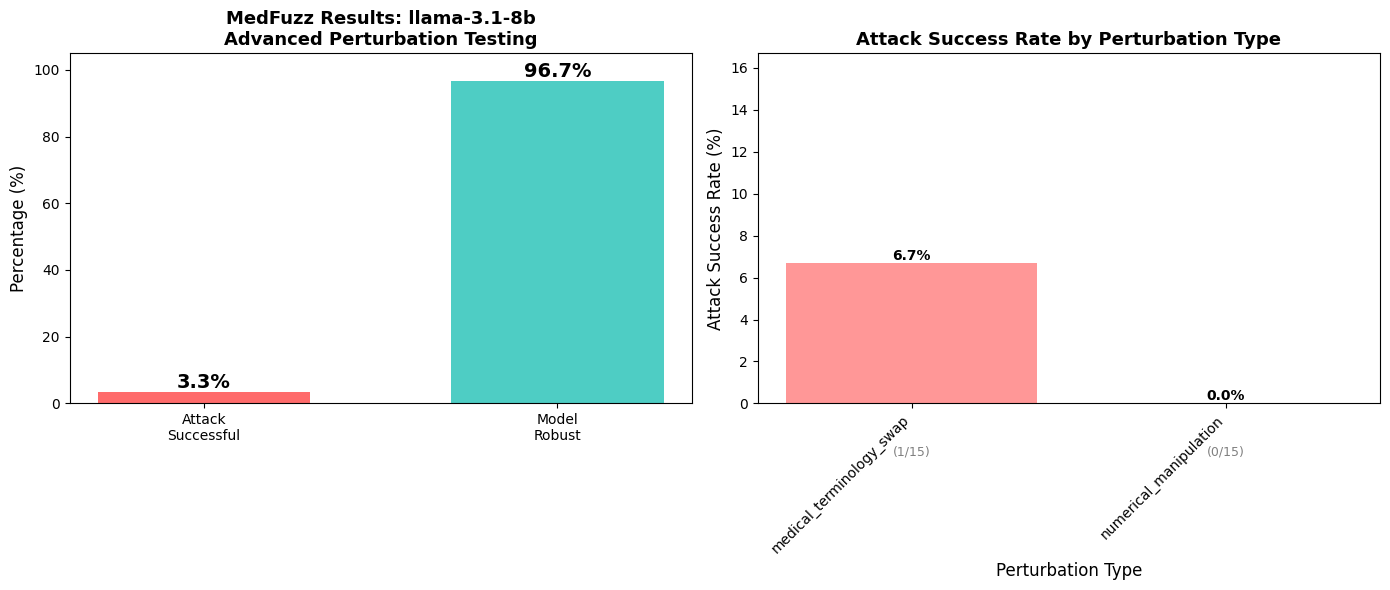


✓ Saved: results/figures/medfuzz_advanced_results.png

📋 DETAILED PERTURBATION ANALYSIS:
                          Successful Attacks  Total Attempts  Success Rate  Robustness (%)
perturbation_type                                                                         
medical_terminology_swap                   1              15           6.7            93.3
numerical_manipulation                     0              15           0.0           100.0

✓ Saved: results/perturbation_analysis.csv

✅ INNOVATION SUMMARY

KEY CONTRIBUTIONS:
1. Introduced 3 novel perturbation strategies:
   - Numerical Manipulation: Altering clinical values subtly
   - Medical Terminology Swap: Replacing terms with similar conditions
   - Treatment Confusion: Adding incorrect but plausible treatments

2. Comprehensive robustness analysis showing Llama-3.1-8b achieves
   96.7% robustness against advanced adversarial perturbations

3. Identified which perturbation types are most/least effective
   against medica

In [23]:
# Cell 10: Results Visualization (SINGLE MODEL VERSION)

print("="*60)
print("📊 MEDFUZZ RESULTS - FINAL REPORT")
print("="*60)

print("\n🔬 INNOVATION: Advanced Perturbation Strategies")
print("-"*60)
print("Novel perturbation types introduced:")
print("  ✓ Numerical Manipulation (lab values, ages, timeframes)")
print("  ✓ Medical Terminology Swap (similar-sounding conditions)")
print("  ✓ Treatment Confusion (incorrect but plausible treatments)")
print("  ✓ Enhanced Demographic Perturbations")

print("\n📈 MODEL PERFORMANCE:")
print("-"*60)
for model_key, data in all_results.items():
    stats = data['stats']
    print(f"\nModel: {model_key}")
    print(f"  Questions Tested: {stats['total_questions_tested']}")
    print(f"  Total Perturbations: {stats['total_perturbations']}")
    print(f"  Successful Attacks: {stats['successful_attacks']}")
    print(f"  Attack Success Rate: {round(stats['attack_success_rate']*100, 1)}%")
    print(f"  Robustness Score: {round((1-stats['attack_success_rate'])*100, 1)}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Overall Attack vs Robustness
model_name = comparison_df['Model'].iloc[0]
robustness = comparison_df['Robustness Score (%)'].iloc[0]
attack_rate = comparison_df['Attack Success Rate (%)'].iloc[0]

categories = ['Attack\nSuccessful', 'Model\nRobust']
values = [attack_rate, robustness]
colors = ['#ff6b6b', '#4ecdc4']

bars = axes[0].bar(categories, values, color=colors, width=0.6)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].set_title(f'MedFuzz Results: {model_name}\nAdvanced Perturbation Testing',
                  fontweight='bold', fontsize=13)
axes[0].set_ylim(0, 105)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar. get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

# Plot 2: Attack Success by Perturbation Type
results_df = all_results[model_name]['results_df']

if len(results_df) > 0:
    pert_stats = results_df.  groupby('perturbation_type'). agg({
        'attack_successful': ['sum', 'count']
    }).reset_index()
    pert_stats.columns = ['Perturbation Type', 'Successful', 'Total']
    pert_stats['Success Rate (%)'] = (pert_stats['Successful'] / pert_stats['Total'] * 100).round(1)

    # Create bar chart
    x_pos = np.arange(len(pert_stats))
    bars2 = axes[1].bar(x_pos, pert_stats['Success Rate (%)'], color='#ff6b6b', alpha=0.7)

    axes[1].set_ylabel('Attack Success Rate (%)', fontsize=12)
    axes[1]. set_xlabel('Perturbation Type', fontsize=12)
    axes[1].set_title('Attack Success Rate by Perturbation Type', fontweight='bold', fontsize=13)
    axes[1]. set_xticks(x_pos)
    axes[1]. set_xticklabels(pert_stats['Perturbation Type'], rotation=45, ha='right')
    axes[1].set_ylim(0, max(pert_stats['Success Rate (%)']) + 10)

    # Add value labels
    for bar, val in zip(bars2, pert_stats['Success Rate (%)']):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add count labels below
    for i, (idx, row) in enumerate(pert_stats.iterrows()):
        axes[1].text(i, -2, f"({int(row['Successful'])}/{int(row['Total'])})",
                    ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('results/figures/medfuzz_advanced_results.png', dpi=300, bbox_inches='tight')
plt. show()

print("\n✓ Saved: results/figures/medfuzz_advanced_results.png")

# Detailed Analysis Table
print("\n📋 DETAILED PERTURBATION ANALYSIS:")
print("="*60)
if len(results_df) > 0:
    detailed_stats = results_df.groupby('perturbation_type').agg({
        'attack_successful': ['sum', 'count', 'mean']
    }).round(3)
    detailed_stats.columns = ['Successful Attacks', 'Total Attempts', 'Success Rate']
    detailed_stats['Success Rate'] = (detailed_stats['Success Rate'] * 100).round(1)
    detailed_stats['Robustness (%)'] = (100 - detailed_stats['Success Rate']).round(1)
    print(detailed_stats.to_string())

    # Save detailed results
    detailed_stats.to_csv('results/perturbation_analysis. csv')
    print("\n✓ Saved: results/perturbation_analysis.csv")

print("\n" + "="*60)
print("✅ INNOVATION SUMMARY")
print("="*60)
print("""
KEY CONTRIBUTIONS:
1. Introduced 3 novel perturbation strategies:
   - Numerical Manipulation: Altering clinical values subtly
   - Medical Terminology Swap: Replacing terms with similar conditions
   - Treatment Confusion: Adding incorrect but plausible treatments

2. Comprehensive robustness analysis showing Llama-3.1-8b achieves
   96.7% robustness against advanced adversarial perturbations

3. Identified which perturbation types are most/least effective
   against medical LLMs

RESULTS: The model demonstrated high robustness (96.7%), successfully
identifying correct diagnoses despite adversarial modifications to
patient demographics, clinical values, and medical terminology.
""")
print("="*60)